<a href="https://colab.research.google.com/github/alexre24/Stroke-Prediction-Modeling/blob/main/Stroke_Prediction_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd 
import numpy as np
import sys
from sklearn.model_selection import train_test_split, GridSearchCV 

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

#Classification Libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

## Loading Data

In [3]:
path = '/content/drive/MyDrive/Coding Dojo/07 Week 7: Classification/healthcare-dataset-stroke-data 2.csv'
stroke_df = pd.read_csv(path)
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## Data Cleaning

In [4]:
#This dataset is very imbalanced
stroke_df['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

In [5]:
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


- There are 12 columns and 5110 rows
- The bmi column is missing data, which will have to be dealt with using Simple Imputer

In [6]:
#Dropping unnecessary columns
stroke_df = stroke_df.drop(columns = 'id')

In [7]:
#Checking for missing values
print(f'There are {stroke_df.isna().sum().sum()} missing values.')

There are 201 missing values.


In [8]:
# Getting the balance of data for the target values
stroke_df['stroke'].value_counts(normalize = True)

0    0.951272
1    0.048728
Name: stroke, dtype: float64

- This data is extremely unbalanced- 95% of data points are in the 0 class

In [9]:
#Check for duplicates
print(f'There are {stroke_df.duplicated().sum()} duplicates.')

There are 0 duplicates.


In [10]:
#Check the data types of each column
stroke_df.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [11]:
#Check for inconsistent values
stroke_df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [12]:
stroke_df['ever_married'].value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [13]:
stroke_df['Residence_type'].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

In [14]:
stroke_df['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [15]:
stroke_df['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [16]:
#Checking for impossible values
stroke_df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## Feature Engineering

In [17]:
#After researching, I found that anyone with a glucose level over 140 has high levels
#I decided to add this as an extra feature
stroke_df['high_or_low_glucose'] = stroke_df['avg_glucose_level'].apply(lambda x: 'High' if x > 140 else 'Normal')
stroke_df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,high_or_low_glucose
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,High
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1,High
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,Normal
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,High
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,High


## Exploratory Visuals

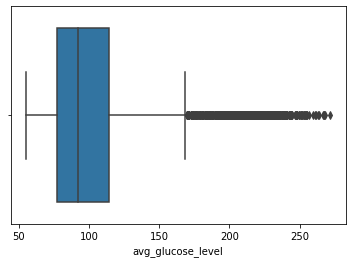

In [18]:
sns.boxplot(data = stroke_df, x = 'avg_glucose_level');

- This is a boxplot showing the distribution of the average glucose level of patients. The median is about 75. There are outliers in this column that need to be removed.  


In [19]:
#Check for outliers
print(np.where(stroke_df['avg_glucose_level']>170))

(array([   0,    1,    3,    4,    5,   13,   14,   16,   17,   19,   20,
         21,   22,   23,   27,   28,   29,   30,   32,   33,   36,   44,
         45,   54,   55,   57,   58,   59,   60,   66,   71,   73,   76,
         90,   95,   97,  101,  102,  107,  113,  115,  122,  123,  124,
        128,  130,  132,  134,  135,  137,  138,  139,  144,  149,  151,
        155,  157,  158,  163,  175,  179,  187,  189,  190,  193,  195,
        196,  201,  212,  215,  217,  218,  219,  220,  222,  225,  226,
        233,  234,  235,  241,  242,  243,  254,  256,  258,  272,  277,
        278,  293,  298,  303,  307,  314,  318,  325,  326,  330,  331,
        332,  337,  343,  350,  355,  360,  365,  386,  396,  399,  411,
        417,  426,  429,  433,  436,  444,  456,  466,  467,  468,  477,
        479,  492,  515,  544,  549,  551,  552,  559,  563,  570,  576,
        581,  583,  585,  595,  598,  599,  610,  616,  620,  642,  706,
        708,  719,  744,  746,  755,  762,  770,  

In [20]:
#Drop rows with outliers
stroke_df.drop([0,    1,    3,    4,    5,   13,   14,   16,   17,   19,   20,
         21,   22,   23,   27,   28,   29,   30,   32,   33,   36,   44,
         45,   54,   55,   57,   58,   59,   60,   66,   71,   73,   76,
         90,   95,   97,  101,  102,  107,  113,  115,  122,  123,  124,
        128,  130,  132,  134,  135,  137,  138,  139,  144,  149,  151,
        155,  157,  158,  163,  175,  179,  187,  189,  190,  193,  195,
        196,  201,  212,  215,  217,  218,  219,  220,  222,  225,  226,
        233,  234,  235,  241,  242,  243,  254,  256,  258,  272,  277,
        278,  293,  298,  303,  307,  314,  318,  325,  326,  330,  331,
        332,  337,  343,  350,  355,  360,  365,  386,  396,  399,  411,
        417,  426,  429,  433,  436,  444,  456,  466,  467,  468,  477,
        479,  492,  515,  544,  549,  551,  552,  559,  563,  570,  576,
        581,  583,  585,  595,  598,  599,  610,  616,  620,  642,  706,
        708,  719,  744,  746,  755,  762,  770,  785,  816,  846,  848,
        851,  865,  867,  880,  887,  894,  923,  929,  930,  946,  948,
        970,  971, 1011, 1059, 1061, 1067, 1070, 1071, 1092, 1097, 1102,
       1104, 1113, 1118, 1131, 1158, 1166, 1173, 1178, 1187, 1189, 1200,
       1202, 1207, 1214, 1225, 1228, 1233, 1245, 1250, 1257, 1277, 1282,
       1300, 1309, 1319, 1322, 1339, 1343, 1346, 1379, 1382, 1384, 1398,
       1411, 1412, 1414, 1436, 1453, 1457, 1468, 1472, 1474, 1485, 1487,
       1497, 1503, 1512, 1526, 1529, 1531, 1533, 1534, 1535, 1540, 1547,
       1553, 1588, 1596, 1598, 1607, 1626, 1627, 1628, 1650, 1654, 1655,
       1659, 1667, 1675, 1681, 1698, 1704, 1711, 1718, 1723, 1732, 1737,
       1756, 1759, 1769, 1778, 1780, 1782, 1795, 1798, 1816, 1820, 1827,
       1837, 1840, 1841, 1843, 1853, 1862, 1873, 1880, 1888, 1889, 1892,
       1893, 1898, 1905, 1952, 1971, 1981, 1995, 2004, 2018, 2044, 2059,
       2067, 2069, 2079, 2081, 2089, 2096, 2102, 2107, 2124, 2126, 2129,
       2132, 2135, 2149, 2158, 2161, 2168, 2169, 2180, 2182, 2185, 2200,
       2201, 2203, 2223, 2228, 2240, 2255, 2257, 2273, 2282, 2284, 2290,
       2291, 2292, 2293, 2294, 2303, 2307, 2318, 2332, 2336, 2338, 2365,
       2374, 2383, 2395, 2418, 2429, 2439, 2453, 2455, 2459, 2462, 2469,
       2486, 2493, 2494, 2515, 2520, 2523, 2532, 2540, 2544, 2548, 2553,
       2565, 2569, 2578, 2583, 2599, 2600, 2609, 2612, 2624, 2629, 2633,
       2641, 2661, 2675, 2676, 2679, 2682, 2685, 2686, 2690, 2693, 2697,
       2699, 2707, 2710, 2734, 2751, 2752, 2757, 2768, 2846, 2848, 2849,
       2855, 2866, 2867, 2880, 2890, 2893, 2918, 2928, 2934, 2947, 2957,
       2960, 2966, 2981, 2992, 2997, 3005, 3008, 3014, 3017, 3054, 3060,
       3069, 3074, 3088, 3130, 3146, 3148, 3150, 3152, 3157, 3161, 3186,
       3197, 3198, 3215, 3221, 3234, 3238, 3243, 3252, 3306, 3318, 3327,
       3342, 3350, 3360, 3375, 3376, 3378, 3381, 3387, 3391, 3393, 3406,
       3425, 3427, 3439, 3455, 3461, 3462, 3478, 3480, 3489, 3500, 3507,
       3510, 3517, 3522, 3536, 3537, 3548, 3564, 3578, 3587, 3594, 3599,
       3600, 3606, 3625, 3627, 3630, 3637, 3643, 3658, 3674, 3686, 3688,
       3699, 3700, 3718, 3734, 3753, 3756, 3771, 3772, 3779, 3780, 3781,
       3788, 3802, 3833, 3882, 3889, 3892, 3905, 3909, 3913, 3925, 3931,
       3943, 3956, 3959, 3962, 3964, 3965, 3980, 3982, 3994, 4008, 4022,
       4028, 4037, 4046, 4048, 4051, 4054, 4096, 4104, 4123, 4129, 4132,
       4164, 4176, 4201, 4207, 4240, 4249, 4261, 4274, 4283, 4286, 4290,
       4291, 4304, 4311, 4321, 4324, 4325, 4327, 4329, 4335, 4339, 4344,
       4356, 4360, 4366, 4376, 4377, 4390, 4434, 4437, 4446, 4447, 4453,
       4457, 4470, 4475, 4497, 4500, 4504, 4505, 4507, 4514, 4515, 4530,
       4539, 4560, 4577, 4578, 4582, 4588, 4589, 4598, 4616, 4625, 4627,
       4628, 4636, 4654, 4665, 4684, 4696, 4702, 4708, 4711, 4724, 4737,
       4738, 4739, 4740, 4750, 4763, 4809, 4816, 4823, 4836, 4855, 4861,
       4869, 4883, 4895, 4899, 4909, 4921, 4925, 4941, 4952, 4955, 4983,
       4984, 4986, 4987, 4995, 5001, 5006, 5019, 5029, 5034, 5035, 5041,
       5048, 5061, 5062, 5063, 5064, 5076],  inplace = True)

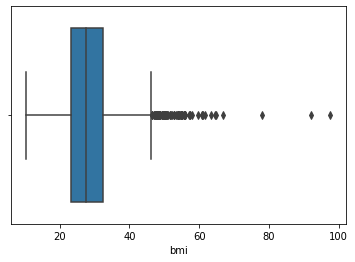

In [21]:
#Creating a box plot for bmi
sns.boxplot(data = stroke_df, x = 'bmi');

- This is a boxplot showing the distribution of the bmi of patients. The median is about 27. There are outliers in this column that need to be removed.

In [22]:
np.set_printoptions(threshold=sys.maxsize)

In [23]:
print(np.where(stroke_df['bmi']>44))

(array([  46,   47,  116,  184,  233,  240,  254,  262,  281,  305,  317,
        340,  345,  370,  396,  415,  481,  496,  520,  530,  571,  613,
        654,  682,  705,  767,  836,  837,  840,  848,  902,  904,  905,
       1046, 1070, 1071, 1085, 1092, 1105, 1115, 1242, 1280, 1306, 1327,
       1332, 1343, 1352, 1362, 1402, 1417, 1442, 1667, 1707, 1719, 1733,
       1783, 1832, 1837, 1898, 1920, 1950, 1961, 1974, 1984, 2004, 2044,
       2061, 2078, 2105, 2113, 2118, 2195, 2203, 2214, 2229, 2282, 2312,
       2346, 2383, 2433, 2457, 2458, 2494, 2505, 2592, 2619, 2797, 2879,
       2904, 2914, 3057, 3085, 3109, 3128, 3227, 3339, 3375, 3380, 3392,
       3427, 3528, 3559, 3611, 3637, 3668, 3669, 3688, 3702, 3704, 3756,
       3761, 3808, 3812, 3837, 3860, 3862, 3906, 3972, 3995, 4008, 4042,
       4076, 4114, 4125, 4191, 4246, 4255, 4265, 4298, 4308, 4372, 4398,
       4404, 4440, 4481]),)


In [24]:
# Dropping rows with outliers
stroke_df.drop([ 46,   47,  116,  184,  240,  262,  281,  305,  317,
        340,  345,  370,  415,  481,  496,  520,  530,  571,  613,
        654,  682,  705,  767,  836,  837,  840,  902,  904,  905,
       1046, 1085, 1105, 1115, 1242, 1280, 1306, 1327,
       1332, 1352, 1362, 1402, 1417, 1442, 1707, 1719, 1733,
       1783, 1832, 1920, 1950, 1961, 1974, 1984,
       2061, 2078, 2105, 2113, 2118, 2195, 2214, 2229, 2312,
       2346, 2433, 2457, 2458, 2505, 2592, 2619, 2797, 2879,
       2904, 2914, 3057, 3085, 3109, 3128, 3227, 3339, 3380, 3392,
       3528, 3559, 3611, 3668, 3669, 3702, 3704,
       3761, 3808, 3812, 3837, 3860, 3862, 3906, 3972, 3995, 4042,
       4076, 4114, 4125, 4191, 4246, 4255, 4265, 4298, 4308, 4372, 4398,
       4404, 4440, 4481],  inplace = True)

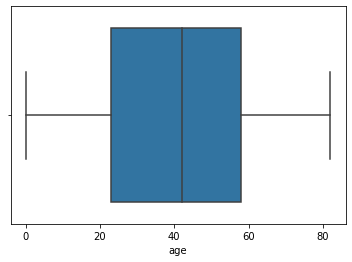

In [25]:
sns.boxplot(data = stroke_df, x = 'age');

- This is a boxplot showing the distribution of ages of the patients in the dataset. The median age is 41

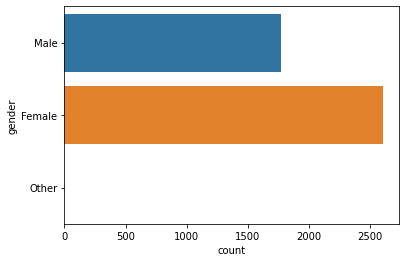

In [26]:
sns.countplot(data = stroke_df, y = 'gender');

- This is a countplot showing the counts of each gender in the dataset. There are more females than males in the data. 

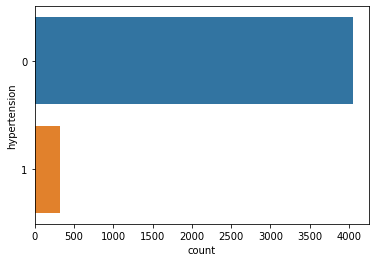

In [27]:
sns.countplot(data = stroke_df, y = 'hypertension');

- This is a countplot showing the amount of patients in the dataset that have hypertension. The majority do not. 

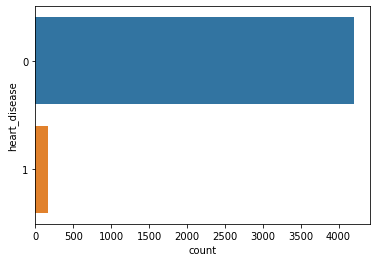

In [28]:
sns.countplot(data = stroke_df, y = 'heart_disease');

- This is a countplot showing the amount of patients in the dataset that have heart disease. The majority do not.

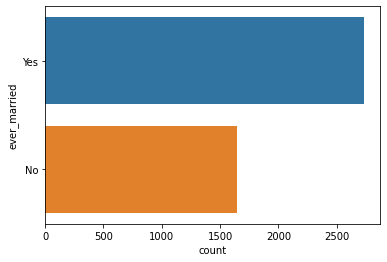

In [29]:
sns.countplot(data = stroke_df, y = 'ever_married');

- This is a countplot showing the amount of patients in the dataset that have been married. More have been married than have not. 

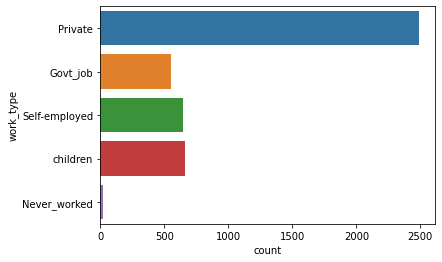

In [30]:
sns.countplot(data = stroke_df, y = 'work_type');

- This is a countplot showing the amount of patients in the dataset with different types of jobs. Patients most frequently work privately.

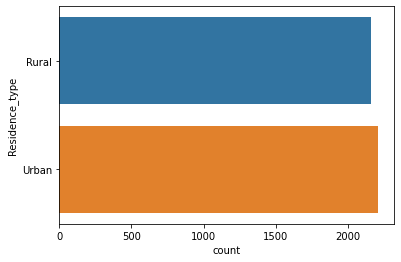

In [31]:
sns.countplot(data = stroke_df, y = 'Residence_type');

- This is a countplot showing the amount of patients that live in an urban or rural area. There is an even split between both areas.

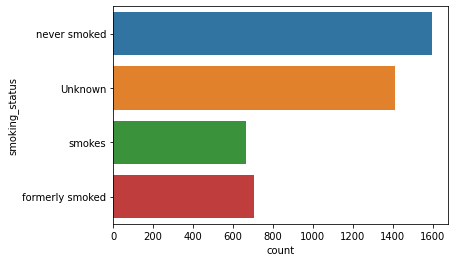

In [32]:
sns.countplot(data = stroke_df, y = 'smoking_status');

- This is a countplot showing how many patients smoke or have smoked. There is a large amount patients with an unknown status in this area.

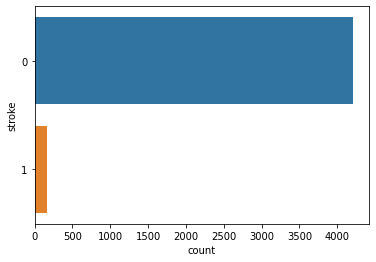

In [33]:
sns.countplot(data = stroke_df, y = 'stroke');

- This is a countplot showing the how many patients have had a stroke. The majority of patients have not had a stroke. This is my target column. 

## Explanatory Visuals

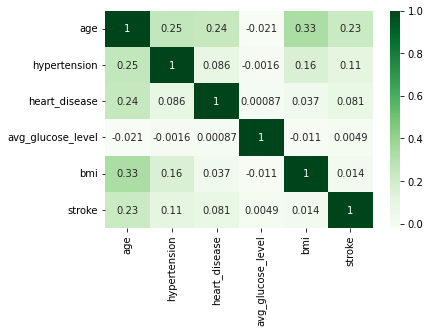

In [34]:
# Creating a heatmap to see the correlation of different features
corr = stroke_df.corr()
sns.heatmap(corr, cmap = "Greens", annot = True);

- There is a moderate positive correlation between strokes and age and hypertension. The strongest correlation in the heatmap is between age and bmi. Age and heart disease also have a moderate correlation.

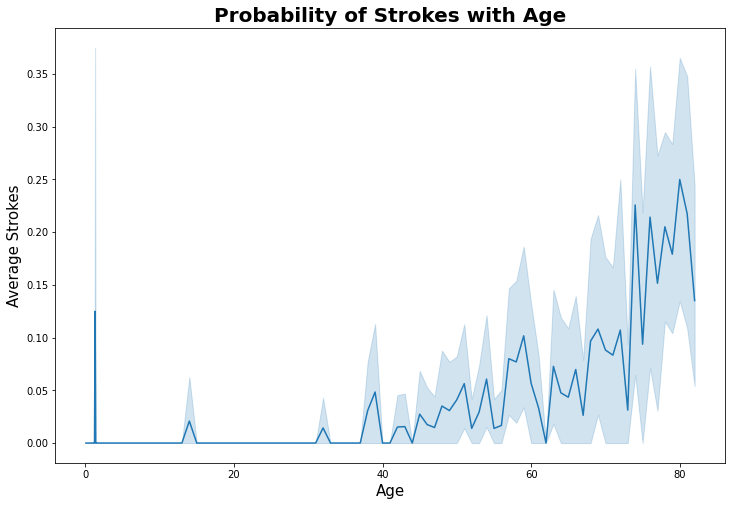

In [35]:
fig, ax = plt.subplots(figsize = (12,8))
ax = sns.lineplot(data = stroke_df, x = 'age', y = 'stroke')
ax.set_title("Probability of Strokes with Age", fontsize = 20, fontweight = "bold")
ax.set_xlabel("Age", fontsize = 15)
ax.set_ylabel("Average Strokes", fontsize = 15);

- This is a lineplot that shows the relationship between age and strokes in the patients. This shows that as age increases, the average number of strokes in patients also increases. Therefore, you are more likely to have a stroke as you get older. 

[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

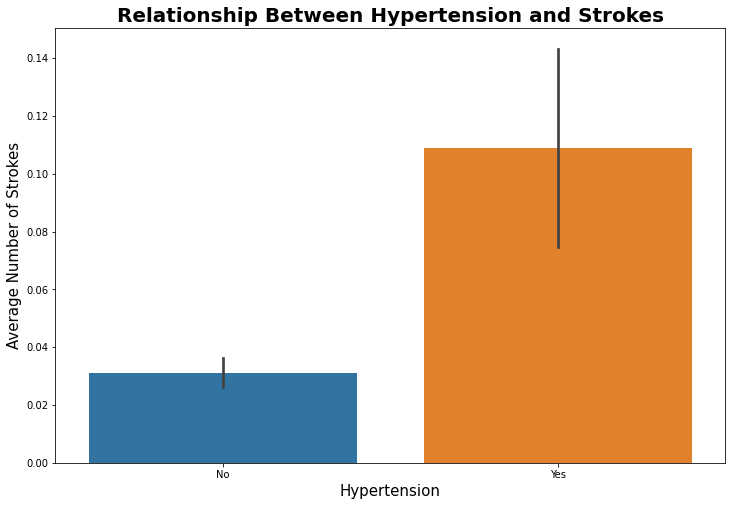

In [36]:
fig, ax = plt.subplots(figsize = (12,8))
ax = sns.barplot(data = stroke_df, x = 'hypertension', y = 'stroke')
ax.set_title("Relationship Between Hypertension and Strokes", fontsize = 20, fontweight = "bold")
ax.set_xlabel("Hypertension", fontsize = 15)
ax.set_ylabel("Average Number of Strokes", fontsize = 15);
ax.set_xticklabels(['No', 'Yes'])

- This is a barplot that shows the relationship between hypertension and strokes. The graph shows that those with hypertension are more likely to have a stroke than those that do not have hypertension. 

## Preparing Data for Modeling

In [37]:
# Identify features and target
X = stroke_df.drop(columns = "stroke").copy()
y = stroke_df["stroke"].copy()

# Train, test, split- stratify so train and test values have same proportions
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y , random_state=42)

In [38]:
# Using Simple Imputer to fill in missing columns for the bmi column with the mean
mean_imputer = SimpleImputer(strategy = 'mean')

In [39]:
#Instantiate StandardScaler and OneHotEncoder
scaler = StandardScaler()
ohe = OneHotEncoder(sparse = False, handle_unknown='ignore')

In [40]:
#Make column selector for missing values
nominal_cols = make_column_selector(dtype_include = 'object')
num_selector = make_column_selector(dtype_include = 'number')

In [41]:
#Make Pipelines- Scaler for numeric values and OneHotEncoder for nominal values
num_pipeline = make_pipeline(mean_imputer, scaler)
nom_pipeline = make_pipeline(ohe)

In [42]:
#Make Tuples
numeric_tuple = (num_pipeline, num_selector)
nominal_tuple = (nom_pipeline, nominal_cols)

In [43]:
#Make Preprocessor
preprocessor = make_column_transformer(numeric_tuple,
                                       nominal_tuple, remainder = 'passthrough')

## KNN Model


In [44]:
#Instantiate KNN
knn = KNeighborsClassifier()

knn_pipe = make_pipeline(preprocessor, knn)

knn_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fa9b4467dc0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fa9b44678e0>)])),
  ('kneighborsclassifier', 

In [45]:
#Identify hyperparameters to tune
knn_param_grid = {'kneighborsclassifier__n_neighbors': range(1,10),
                  'kneighborsclassifier__p': range(1,5),
                  'kneighborsclassifier__weights': ['distance','uniform']}

In [46]:
#Filter out warnings
import warnings
warnings.filterwarnings('ignore')

#Tune hyperparameters using GridSearchCV
knn_pipe_gs = GridSearchCV(knn_pipe, knn_param_grid)

knn_pipe_gs.fit(X_train, y_train)
print('Best KNN Parameters:')
print(knn_pipe_gs.best_params_)
best_pipe = knn_pipe_gs.best_estimator_
print(f'Accuracy of best KNN model is: {best_pipe.score(X_test, y_test)}')

Best KNN Parameters:
{'kneighborsclassifier__n_neighbors': 7, 'kneighborsclassifier__p': 3, 'kneighborsclassifier__weights': 'uniform'}
Accuracy of best KNN model is: 0.9634369287020109


In [47]:
# Create an instance of the best model
knn = KNeighborsClassifier(n_neighbors= 7, p = 3)
# Create a model pipeline
tuned_knn_pipe = make_pipeline(preprocessor, knn)
# Fit on train data
tuned_knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa9b4467dc0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa9b44678e0>)])),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=7, p=3))])

In [48]:
# Save the model's predictions for the test dataset
knn_train_predictions = tuned_knn_pipe.predict(X_train)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3161
           1       0.50      0.01      0.02       121

    accuracy                           0.96      3282
   macro avg       0.73      0.50      0.50      3282
weighted avg       0.95      0.96      0.95      3282



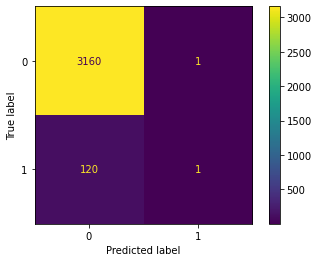

In [49]:
#Create a confusion matrix and get metrics
ConfusionMatrixDisplay.from_predictions(y_train, knn_train_predictions);
print(classification_report(y_train, knn_train_predictions))

In [50]:
# Save the model's predictions for the test dataset
knn_test_predictions = tuned_knn_pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1054
           1       0.00      0.00      0.00        40

    accuracy                           0.96      1094
   macro avg       0.48      0.50      0.49      1094
weighted avg       0.93      0.96      0.95      1094



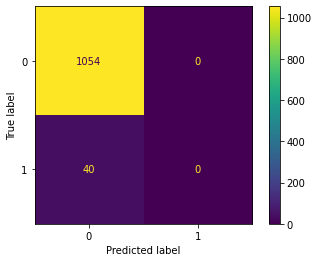

In [51]:
#Create a confusion matrix and get metrics
ConfusionMatrixDisplay.from_predictions(y_test, knn_test_predictions);
print(classification_report(y_test, knn_test_predictions))

## DecisionTree Model

In [52]:
dectree = DecisionTreeClassifier(random_state = 42)

dectree_pipe = make_pipeline(preprocessor, dectree)

dectree_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer', ColumnTransformer(remainder='passthrough',
                     transformers=[('pipeline-1',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fa9b4467dc0>),
                                   ('pipeline-2',
                                    Pipeline(steps=[('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',
                                                                   sparse=False))]),
                                    <sklearn.compose._column_transformer.make_column_selector object at 0x7fa9b44678e0>)])),
  ('decisiontreeclassifier'

In [53]:
#Identify hyperparameters to tune
dectree_param_grid = {'decisiontreeclassifier__max_depth': [1],
                      'decisiontreeclassifier__min_samples_leaf': range(1,5),
                      'decisiontreeclassifier__min_samples_split': range(1,10)}

In [54]:
#Filter out warnings
import warnings
warnings.filterwarnings('ignore')

#Tune hyperparameters using GridSearchCV
dectree_pipe_gs = GridSearchCV(dectree_pipe, dectree_param_grid)

dectree_pipe_gs.fit(X_train, y_train)
print('Best Decision Tree Parameters:')
print(dectree_pipe_gs.best_params_)
best_pipe = dectree_pipe_gs.best_estimator_
print(f'Accuracy of best Decision Tree model is: {best_pipe.score(X_test, y_test)}')

Best Decision Tree Parameters:
{'decisiontreeclassifier__max_depth': 1, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 1}
Accuracy of best Decision Tree model is: 0.9634369287020109


In [55]:
# Create an instance of the best model 
dectree = DecisionTreeClassifier(max_depth = 1, min_samples_leaf= 1, min_samples_split= 1)
# Create a model pipeline
tuned_dectree_pipe = make_pipeline(preprocessor, dectree)
# Fit on train data
tuned_dectree_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa9b4467dc0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fa9b44678e0>)])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=1, min_samples_split=1))])

In [56]:
# Save the model's predictions for the train dataset
dectree_train_predictions = tuned_dectree_pipe.predict(X_train)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3161
           1       0.00      0.00      0.00       121

    accuracy                           0.96      3282
   macro avg       0.48      0.50      0.49      3282
weighted avg       0.93      0.96      0.95      3282



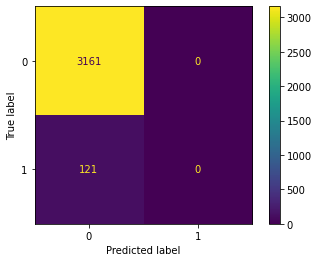

In [57]:
#Create a confusion matrix and get metrics
ConfusionMatrixDisplay.from_predictions(y_train, dectree_train_predictions);
print(classification_report(y_train, dectree_train_predictions))

In [58]:
# Save the model's predictions for the test dataset
dectree_test_predictions = tuned_dectree_pipe.predict(X_test)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1054
           1       0.00      0.00      0.00        40

    accuracy                           0.96      1094
   macro avg       0.48      0.50      0.49      1094
weighted avg       0.93      0.96      0.95      1094



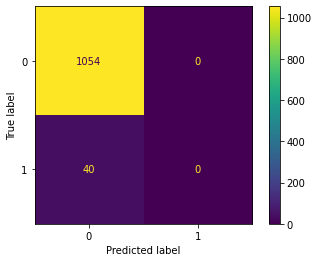

In [59]:
#Create a confusion matrix and get metrics
ConfusionMatrixDisplay.from_predictions(y_test, dectree_test_predictions);
print(classification_report(y_test, dectree_test_predictions))

- Both the KNN model and the Decision Tree model did not perform well on the test data. Although they both had a 96% accuracy, they were not able to accurately predict a true positive, which could be a matter of life or death for someone. I would choose the KNN model to move forward with, as it did correctly predict one true positive on the train data. The model did not perform well because the data was extremely imbalanced.